In [1]:
%matplotlib notebook
import numpy as np
import helpers
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import regressors
import helpers
import os
import gc

Loaded entropies from file (S=15000, entropy_bins=50)!
Loaded dot-level measures from file (S=2000, Smin=20)!


# Visualise the correlation underlying a regression result
To get a feeling for the size of the effect that we identify using the general linear model I here plot the data together with a selected regressor in a scatter plot and in a box plot with binned regressor values. Data selection and processing follows that of the sequential regression analysis. Specifically, you can choose to combine the presumed response to several sequentially shown dots into the same correlation analysis. This is done by associating the regressor value of a dot with the data value at a given time point after dot onset. For example, if you are interested in the brain response to the 3rd dot 420 ms after its onset, data 620 ms after first dot onset will be associated with the corresponding regressor values. Here are the basic options defining what correlation will be analysed:

In [2]:
# source data file to use
# label mode = mean
file = 'source_epochs_allsubs_HCPMMP1_201708232002.h5'

# label of area that should be investigated
area = 'L_4_ROI-lh'

# time after dot onset (in ms) to investigate
time = 420

# regressor name to investigate
# the first is the main one to investigate, following ones are used for comparison
r_names = ['dot_x', 'dot_y', 'sum_dot_x']
r_name = r_names[0]

# dots to investigate
dots = np.arange(1, 6)

load the data (z-scored)

In [3]:
# load data for these dots
loaddots = np.arange(1, max([5, dots.max()]) + 1)

subjects = helpers.find_available_subjects(megdatadir=helpers.megdatadir)

srcfile = os.path.join('mne_subjects', 'fsaverage', 'bem', file)

with pd.HDFStore(srcfile, 'r') as store:
    epochs = store.select('label_tc', 'subject=2')

times = epochs.index.levels[2]

# index of last time point available for this analysis
tendi = times.searchsorted(times[-1] - (loaddots.max() - 1) * helpers.dotdt * 1000)

epochs_mean = pd.read_hdf(srcfile, 'epochs_mean')
epochs_std = pd.read_hdf(srcfile, 'epochs_std')

# get the times associated with the dots
datat = time + (loaddots - 1) * helpers.dotdt * 1000
assert np.all(datat <= times[-1]), ("The times where you are looking for an "
              "effect have to be within the specified time window")
datat = times[[np.abs(times - t).argmin() for t in datat]]

def load_normalised_data(sub):
    with pd.HDFStore(srcfile, 'r') as store:
        epochs = store.select('label_tc', 'subject=sub')
    
    data = (  epochs.loc[(sub, slice(None), datat), area] 
            - epochs_mean[area]) / epochs_std[area]
    
    data.index = pd.MultiIndex.from_product([epochs.index.levels[1], loaddots], names=['trial', 'dot'])
    
    return data

data = pd.concat([load_normalised_data(sub) for sub in subjects],
                 keys=subjects, names=['subject', 'trial', 'dot'])

gc.collect()

print('loaded data for label "{}" at t0={:d} ms for dots {}'.format(area, time, loaddots))

loaded data for label "L_4_ROI-lh" at t0=420 ms for dots [1 2 3 4 5]


load the regressor values

In [4]:
reg = pd.concat([regressors.trial_dot[r_name].loc[(slice(None), list(dots))]] * subjects.size,
                keys=subjects, names=['subject', 'trial', 'dot'])
reg = pd.DataFrame(reg)
for name in r_names[1:]:
    reg[name] = np.tile(regressors.trial_dot[name].loc[(slice(None), list(dots))].values, subjects.size)

put them into a common data frame

In [5]:
df = pd.concat([data.loc[(slice(None), slice(None), dots)], reg], axis=1)
df.head()

L_4_ROI-lh  dot_x  dot_y  sum_dot_x
subject trial dot                                     
2       1     1      0.454727   12.0   -7.0       12.0
              2     -0.251050  -32.0   -7.0      -20.0
              3      0.023000   87.0   32.0       67.0
              4      1.750876   24.0  -75.0       91.0
              5      0.088535 -135.0   -1.0      -44.0

## Scatter plots

<IPython.core.display.Javascript object>


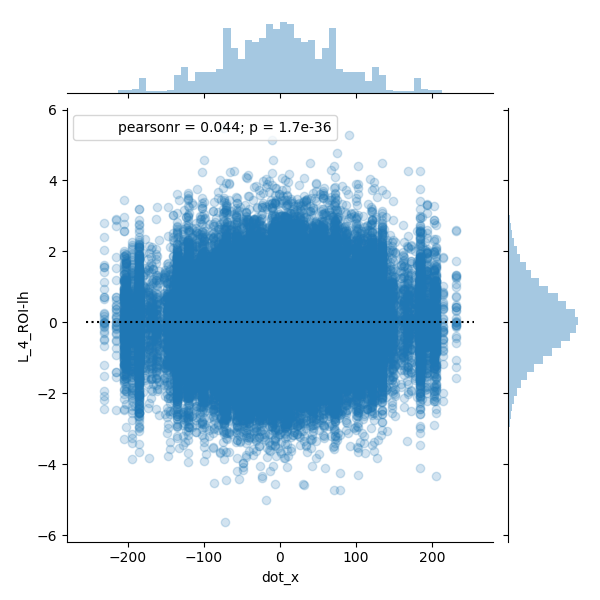

In [6]:
grid = sns.jointplot(r_name, area, data=df, alpha=0.2)
lines = grid.ax_joint.plot(grid.ax_joint.get_xlim(), [0, 0], ':k')

The black dotted line indicates 0 for reference. Data from all trials is pooled across all subjects. It's hard to impossible to detect a correlation visually, but the Pearson correlation coefficient indicates a small, but significant correlation. The value is, by the way, very close to the estimated population level beta-value of the full regression analysis, as expected. Here's a scatter plot with the correlation visualised with a regression line:

<IPython.core.display.Javascript object>


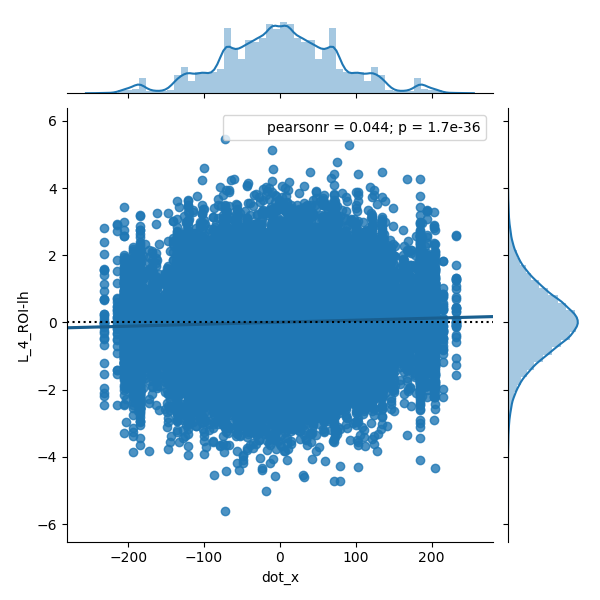

In [7]:
col = [c * 0.8 for c in sns.color_palette()[0]]
grid = sns.jointplot(r_name, area, data=df, kind='reg', line_kws={'color': col})
lines = grid.ax_joint.plot(grid.ax_joint.get_xlim(), [0, 0], ':k')

With so many overlapping data points the raw scatter plot is not very informative and it is better to look at the density of data across the combined data-regressor space. I do this next with a hexbin plot:

<IPython.core.display.Javascript object>


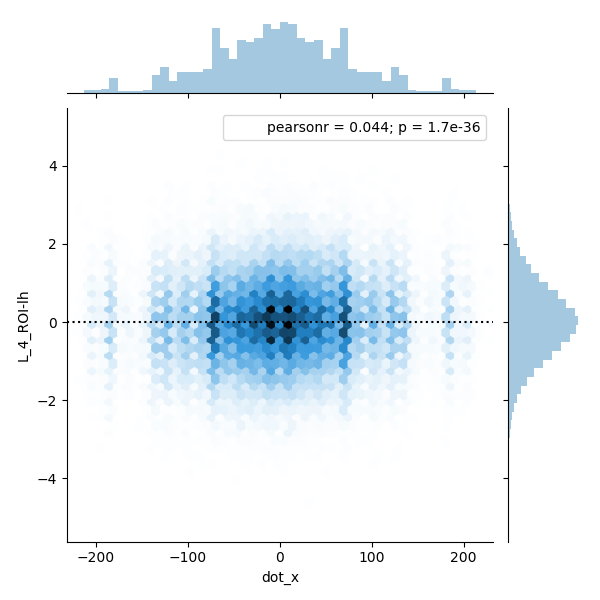

In [8]:
grid = sns.jointplot(r_name, area, data=df, kind='hex')
lines = grid.ax_joint.plot(grid.ax_joint.get_xlim(), [0, 0], ':k')

At least I have the impression that I can spot more prability mass below 0 on one side of 0 than the other, but a small correlation remains a small correlation that is hard to see!

## Boxplot
Another way to look at the correlation is to discretise the regressor values into a few bins and summarise the data falling into these bins. It should then be possible to see whether the correlation is only driven by data in a few bins, or whether all the data contributes to the correlation. 

I discretise based on quantiles:

In [9]:
# bin edges in quantiles of regressor values
# simply divide the data into equally probable bins
bins = np.linspace(0, 1, 8)
# get the actual quantile values
quantiles = df[r_name].quantile(bins).values

# categorise/bin the data according to the quantile bins
# this could be done more easily using pd.cut, but I want that the middle
# bin includes values from both edges while bins to the left of the middle
# include values from the left edge only and vice versa for bins to the right
Q2 = int(quantiles.size / 2)
qnames = np.array(
      ['[{:.0f}, {:.0f})'.format(quantiles[q], quantiles[q+1]) for q in range(Q2-1)] 
    + ['[{:.0f},{:.0f}]'.format(quantiles[Q2-1], quantiles[Q2])]
    + ['({:.0f}, {:.0f}]'.format(quantiles[q], quantiles[q+1]) for q in range(Q2, 2*Q2-1)])
def qmap(x):
    ind = np.r_[(x >= quantiles[:Q2-1]) & (x < quantiles[1:Q2]),
                (x >= quantiles[Q2-1]) & (x <= quantiles[Q2]),
                (x > quantiles[Q2:-1]) & (x <= quantiles[Q2+1:])]
    return qnames[ind][0]

df['bin'] = df[r_name].map(qmap).astype("category", categories=qnames, ordered=True)
df['hue'] = 1

A boxplot is a good way to display the discretised data. The lines of the central box indicate the quartiles of the underlying data (0.25, median, 0.75 quantile):

<IPython.core.display.Javascript object>


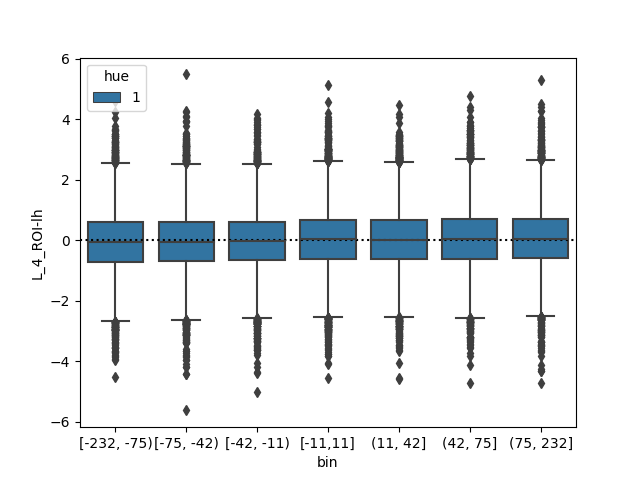

In [10]:
fig, ax = plt.subplots()
ax = sns.boxplot('bin', area, hue='hue', data=df, ax=ax)
line = ax.plot(ax.get_xlim(), [0, 0], ':k')

For a typical positive correlation the medians on the left should lie below 0 and the medians on the right above 0. A gradual change in the difference from the median to 0 is a good sign that all regressor values and data points contribute to the correlation.

## Linear model plot
Because of the many data points in the analysis the small effect is still highly significant. This can be best seen using a plot of the linear regression model underlying the correlation. Instead of showing the data standard deviation, here confidence intervals for the regression and bin means are shown. Seaborn estimates the bins itself, but in a way that should be equivalent to what I did above: It divides the quantiles from 0 to 1 into B+2 evenly spaced values, throws away 0 and 1 and keeps the remaining B quantiles as bin centres. Data are then assigned to the bin for which the corresponding bin centre is closest to the regressor value associated with the data point. 95% confidence intervals for the bin means are computed with bootstrapping. The shown regression line is not based on the bins, but on the raw regressor values.

<IPython.core.display.Javascript object>


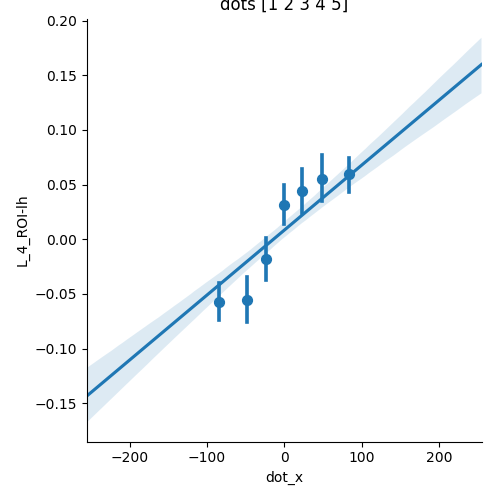

In [11]:
grid = sns.lmplot(r_name, area, df, x_estimator=np.mean, x_bins=bins.size-1)
title = grid.ax.set_title('dots {}'.format(dots))

This plot should show the effect clearest. To be able to say that the magnitude of source currents has a linear relationship with the regressor the bin means should gradually in- or decrease. Because the data is z-scored, the y-axis values can still be easily interpreted in terms of the data variance: A y-value of 0.01 corresponds to a value that is one percent of the data standard deviation larger than the data mean.

Now compare this correlation to correlations with other regressors (note that I normalise the regressors so that their regression coefficients, i.e. slopes, are comparable):

<IPython.core.display.Javascript object>


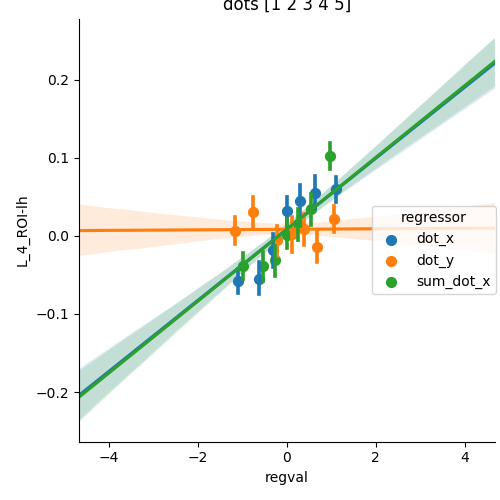

In [12]:
df_norm = pd.concat([df[name] / df[name].std() for name in r_names])
df_norm.name = 'regval'
df_norm = pd.DataFrame(df_norm)
df_norm[area] = np.tile(df[area].values, len(r_names))
df_norm['regressor'] = np.concatenate([np.full(df.shape[0], name) for name in r_names])

grid = sns.lmplot('regval', area, df_norm, hue='regressor', 
                  x_estimator=np.mean, x_bins=bins.size-1)
title = grid.ax.set_title('dots {}'.format(dots))